In [11]:
import numpy as np
import torch
import os
import matplotlib.pyplot as plt

In [12]:
mount_point = "/home/felipe/ExternalDrives"
target_dict = {
    "tiles-annot-train": "tiles-annot-567-train",
    "tiles-annot-val": "tiles-annot-val",
    "tiles-train": "tiles-non-annot-1k-train",
    "tiles-val": "tiles-val",
    "tiles-test": "tiles-test",
}

In [13]:
for key, value in target_dict.items():
    target = os.path.join(mount_point, value)
    print(key, os.listdir(target))

tiles-annot-train ['level-0', 'targets.csv']
tiles-annot-val ['level-0', 'targets.csv']
tiles-train ['level-0']
tiles-val ['level-0']
tiles-test ['level-0']


In [ ]:
from PIL import Image
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms
from tqdm import tqdm


class CADPATH_CRC_Tiles_Dataset(Dataset):
    
    target_dict = {
    "tiles-annot-train": "tiles-annot-567-train",
    "tiles-annot-val": "tiles-annot-val",
    "tiles-train": "tiles-non-annot-1k-train",
    "tiles-val": "tiles-val",
    "tiles-test": "tiles-test",
    }
    
    
    def __init__(self, mount_point, split, is_bag=False):
        assert split in CADPATH_CRC_Tiles_Dataset.target_dict, f"{split} is invalid, please select a valid split: {CADPATH_CRC_Tiles_Dataset.target_dict.keys()}"
        
        self.mount_point = mount_point
        self.split = CADPATH_CRC_Tiles_Dataset.target_dict.get(split)
        self.root = os.path.join(mount_point, self.split)
        self.is_bag = is_bag
        
        assert os.path.exists(self.root), f"path does not exist: {self.root}, please check if external drive is mounted or if mount point is valid"
        
        self.transforms = torchvision.transforms.Compose([
            torchvision.transforms.ToTensor(),
        ])
        
        self.has_annotations = self._are_tiles_annotated()
        if self.has_annotations:
            self.labels = self._load_annotations()
        else:
            self.labels = None
        
        # ids = {int: (slide, tile)}
        self.ids = self._load_ids()
        
    
    def __getitem__(self, index):
        if self.is_bag:
            return self._get_bag(index)
        else:
            return self._get_tile(index)
    
    def _get_tile(self, index):
        id_ = self.ids.get(index)
        if id_ is None:
            raise KeyError("invalid index")
        
        
        id_slide, id_tile = id_
        if self.labels is not None:
            label = self.labels.get(
                self._join_slide_and_tile_ids(id_slide, id_tile)
            )
        else:
            label = None
            
        img_path = os.path.join(
            self.root, "level-0", id_slide,
            self._join_slide_and_tile_ids(id_slide, id_tile)
        )
        img_ = Image.open(img_path + ".png")

        img = self.transforms(img_)
        return img if label is None else img, label
    
    def _get_bag(self, index):
        raise NotImplementedError
    
    def __len__(self):
        if self.is_bag:
            return
        else:
            return len(self.ids)
    
    def _are_tiles_annotated(self):
        return os.path.exists(os.path.join(self.root, "targets.csv"))
    
    def _load_annotations(self):
        targets = pd.read_csv(os.path.join(self.root, "targets.csv"))
        ids = targets["img_id"].values
        labels = targets["target"].values
        return {id_: label for id_, label in zip(ids, labels)}
        
    def _load_ids(self):
        ids = {}
        index = 0
        for file in self._parse_ids(os.path.join(self.root, "level-0")):
            id_ = self._strip_file_extension(file)
            id_slide, id_tile = self._split_slide_and_tile_ids(id_)
            ids[index] = (id_slide, id_tile)    
            index += 1    
        return ids
    
    def _build_tile_bag(self, id_slide):
        pass
    
    def switch_mode(self):
        self.is_bag = not self.is_bag
        return self.is_bag
    
    @staticmethod
    def _split_slide_and_tile_ids(id_):
        slide, tile_1, tile_2 = id_.rsplit("-", 2)
        tile = "-".join([tile_1, tile_2])
        return slide, tile
    
    @staticmethod
    def _join_slide_and_tile_ids(id_slide, id_tile):
        return "-".join([id_slide, id_tile])
        
    @staticmethod
    def _strip_file_extension(filename):
        return filename.rsplit('.', 1)[0]
    
    @staticmethod
    def _parse_ids(root):
        for _, _, files in os.walk(root): 
            for file in files:
                yield file


In [103]:
dataset = CADPATH_CRC_Tiles_Dataset(
    mount_point="/home/felipe/ExternalDrives",
    split="tiles-annot-train",
    is_bag=False,
)

In [107]:
len(dataset)

615492

In [108]:
import einops

def to_plot(x):
    return einops.rearrange(x, "c w h -> w h c")

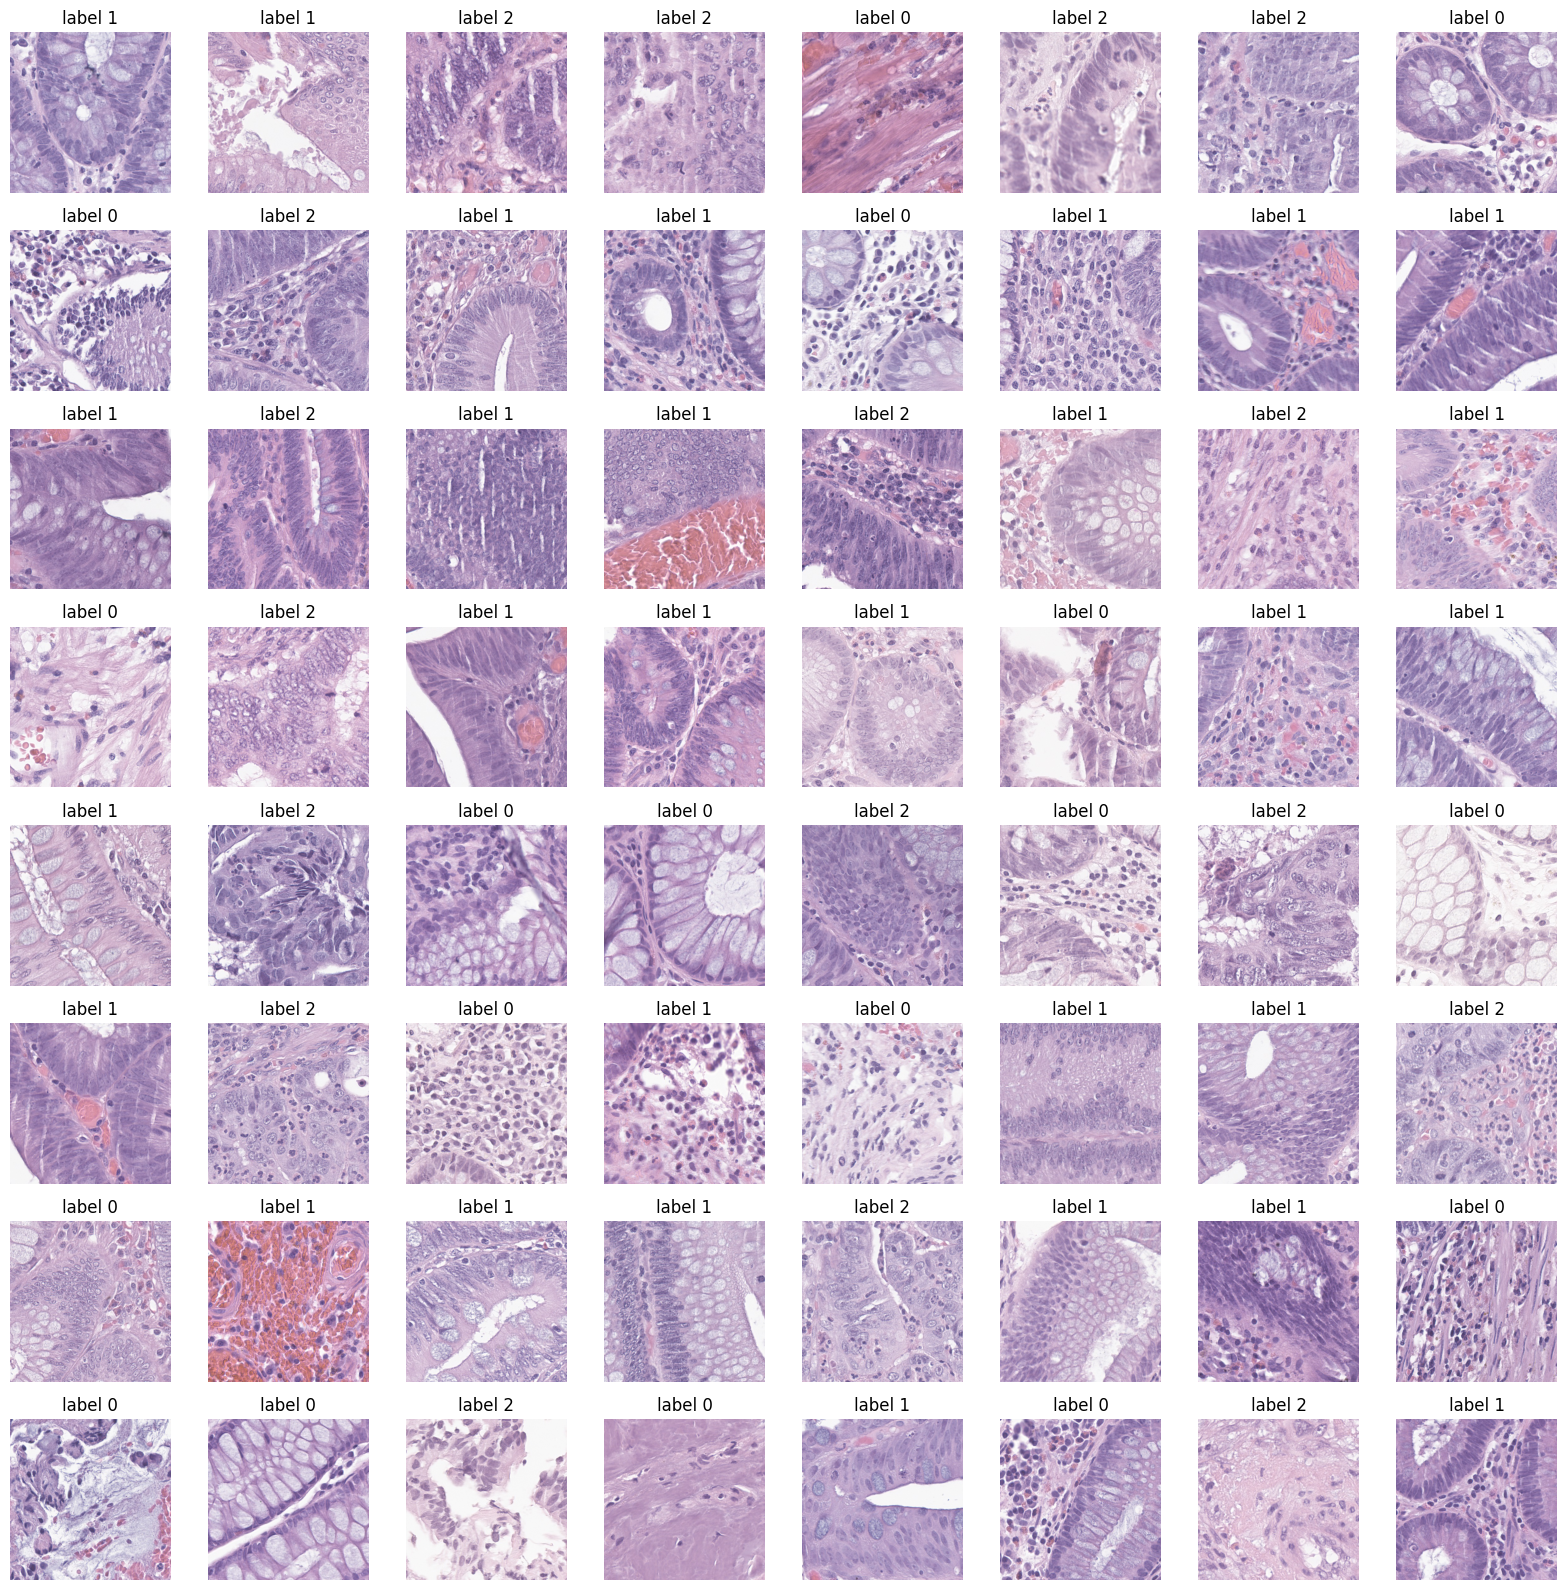

In [109]:
N = 8
fig, axs = plt.subplots(N, N, figsize=(16, 16))

rng = np.random.default_rng()
samples = rng.integers(0, len(dataset), size=N*N)

for i in range(N**2):
    x, y = dataset[samples[i]]
    axs.flatten()[i].imshow(to_plot(x))
    axs.flatten()[i].set_title(f"label {y}")
    axs.flatten()[i].axis("off")
fig.tight_layout()